# Chains in LangChain

## Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  
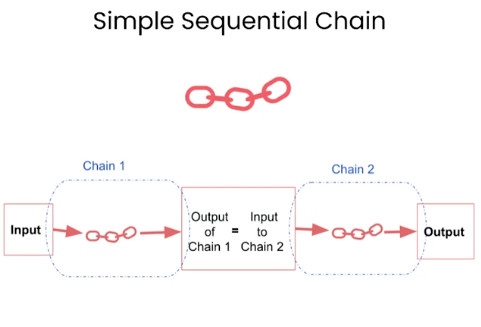
  
  * SequentialChain

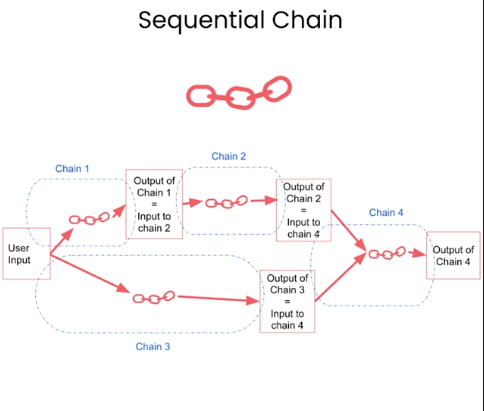
  
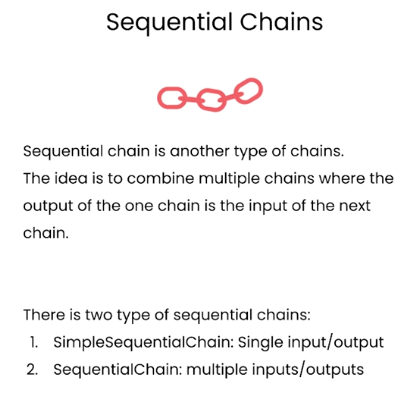

* Router Chain

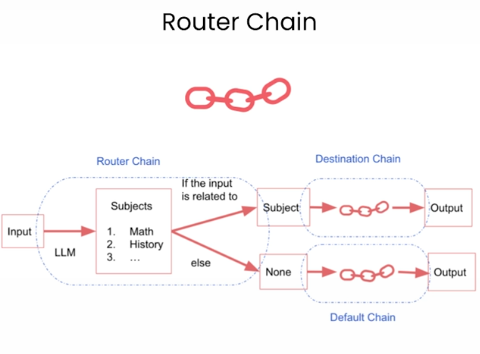

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

Note: LLM's do not always produce the same results. When executing the code in your notebook, you may get slightly different answers that those in the video.

In [33]:
# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"

In [34]:
#!pip install pandas

In [35]:
import pandas as pd
df = pd.read_csv('Data.csv')

In [36]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


## LLMChain

In [37]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [38]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

In [39]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [40]:
chain = LLMChain(llm=llm, prompt=prompt)

In [41]:
product = "Queen Size Sheet Set"
chain.run(product)

'The Royal Linens Company'

## SimpleSequentialChain

In [42]:
from langchain.chains import SimpleSequentialChain

In [43]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [44]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [45]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [46]:
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
Regal Comfort Sheets
Regal Comfort Sheets offers luxurious and stylish bedding solutions to help you create a cozy and elegant bedroom oasis.

> Finished chain.


'Regal Comfort Sheets offers luxurious and stylish bedding solutions to help you create a cozy and elegant bedroom oasis.'

## SequentialChain

In [47]:
from langchain.chains import SequentialChain

In [48]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )


In [49]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [50]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


In [51]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [52]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [53]:
review = df.Review[5]
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'English_Review': "I find the taste mediocre. The foam doesn't hold, it's strange. I buy the same ones in stores and the taste is much better... Old batch or counterfeit!?",
 'summary': 'The reviewer found the taste of the product to be just average and believes it may be an old batch or counterfeit.',
 'followup_message': "Merci pour votre avis honnête sur le produit. Il est possible que vous ayez raison et que ce soit une ancienne version ou une contrefaçon. Je vais prendre en compte votre remarque et faire plus attention à la qualité des produits que j'achète à l'avenir. Merci encore pour votre évaluation sincère."}

## Router Chain

In [66]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

biology_template = """You are a very smart biology professor. \
You are great at answering questions about biology in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""

In [67]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    },
    {
        "name": "biology", 
        "description": "Good for answering biology questions", 
        "prompt_template": biology_template
    }
]

In [68]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [69]:
llm = ChatOpenAI(temperature=0, model=llm_model)

In [70]:

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [71]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [72]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [73]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [75]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [76]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


"Black body radiation refers to the electromagnetic radiation emitted by a perfect black body, which is an idealized physical body that absorbs all incident electromagnetic radiation. The radiation emitted by a black body depends only on its temperature and follows a specific distribution known as Planck's law. This radiation is characterized by a continuous spectrum of wavelengths and intensities, with the peak intensity shifting to shorter wavelengths as the temperature of the black body increases. Black body radiation plays a key role in understanding concepts such as thermal radiation and the quantization of energy in quantum mechanics."

In [77]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'The answer to 2 + 2 is 4.'

In [78]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...
biology: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


'Every cell in our body contains DNA because DNA carries the genetic information that determines the characteristics and functions of each cell. This genetic information is essential for the cell to carry out its specific roles and functions within the body. Additionally, DNA is necessary for cell division and replication, ensuring that new cells have the correct genetic information to function properly.'